# Example-43: Twiss (Computation of Twiss parameters)

In [1]:
# In this example twiss parameters are computed and compared with ELEGANT

In [2]:
# Import

from pprint import pprint

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.corrector import Corrector
from model.library.line import Line

from model.command.util import chop
from model.command.util import select

from model.command.external import load_sdds
from model.command.external import load_lattice

from model.command.build import build

from model.command.tune import tune
from model.command.twiss import twiss

from model.command.layout import Layout

In [3]:
# Load ELEGANT twiss

path = Path('ic.twiss')
parameters, columns = load_sdds(path)

nu_qx:Tensor = torch.tensor(parameters['nux'] % 1, dtype=torch.float64)
nu_qy:Tensor = torch.tensor(parameters['nuy'] % 1, dtype=torch.float64)

# Set twiss parameters at BPMs

kinds = select(columns, 'ElementType', keep=False)

a_qx = select(columns, 'alphax', keep=False)
b_qx = select(columns, 'betax' , keep=False)
a_qy = select(columns, 'alphay', keep=False)
b_qy = select(columns, 'betay' , keep=False)

a_qx:Tensor = torch.tensor([value for (key, value), kind in zip(a_qx.items(), kinds.values()) if kind == 'MONI'], dtype=torch.float64)
b_qx:Tensor = torch.tensor([value for (key, value), kind in zip(b_qx.items(), kinds.values()) if kind == 'MONI'], dtype=torch.float64)
a_qy:Tensor = torch.tensor([value for (key, value), kind in zip(a_qy.items(), kinds.values()) if kind == 'MONI'], dtype=torch.float64)
b_qy:Tensor = torch.tensor([value for (key, value), kind in zip(b_qy.items(), kinds.values()) if kind == 'MONI'], dtype=torch.float64)

positions = select(columns, 's', keep=False).items()
positions = [value for (key, value), kind in zip(positions, kinds.values()) if kind == 'MONI']

In [4]:
# Build and setup lattice

# Note, sextupoles are turned off and dipoles are linear 

# Load ELEGANT table

path = Path('ic.lte')
data = load_lattice(path)

# Build ELEGANT table

ring:Line = build('RING', 'ELEGANT', data)
ring.flatten()

# Merge drifts

ring.merge()

# Turn off sextupoles and set linear dipoles

for element in ring: 
    if element.__class__.__name__ == 'Sextupole':
        element.ms = 0.0
    if element.__class__.__name__ == 'Dipole':
        element.linear = True

# Set number of elements of different kinds

nb = ring.describe['BPM']
nq = ring.describe['Quadrupole']
ns = ring.describe['Sextupole']

In [5]:
# Compute tunes (fractional part)

guess = torch.tensor(4*[0.0], dtype=torch.float64)
nuqx, nuqy = tune(ring, [], alignment=False, matched=True, guess=guess, limit=8, epsilon=1.0E-9)

# Compare with elegant

print(torch.allclose(nu_qx, nuqx))
print(torch.allclose(nu_qy, nuqy))

True
True


In [6]:
# Compute twiss parameters

# For matched flag=True, twiss parameters around closed orbit are computed
# This flag should be used depending on how paramteric variable effect the closed orbit and whether lattice has non-zero correctors
# Note, default values is False

cs = twiss(ring, [], alignment=False, matched=True, advance=True, full=False, guess=guess, limit=8, epsilon=1.0E-9)
aqxs, bqxs, aqys, bqys = cs.T

# Note, by default, twiss parameters at the entrance of each element are returned

print(len(ring))
print(cs.shape)

136
torch.Size([136, 4])


In [7]:
# Compare Twiss parameters at BPMs

aqxs_bpm, bqxs_bpm, aqys_bpm, bqys_bpm = torch.stack([torch.stack([aqx, bqx, aqy, bqy]) for (_, kind, *_), aqx, bqx, aqy, bqy in zip(ring.layout(), aqxs, bqxs, aqys, bqys) if kind == 'BPM']).T

print(torch.allclose(aqxs_bpm, a_qx))
print(torch.allclose(bqxs_bpm, b_qx))
print(torch.allclose(aqys_bpm, a_qy))
print(torch.allclose(bqys_bpm, b_qy))

True
True
True
True


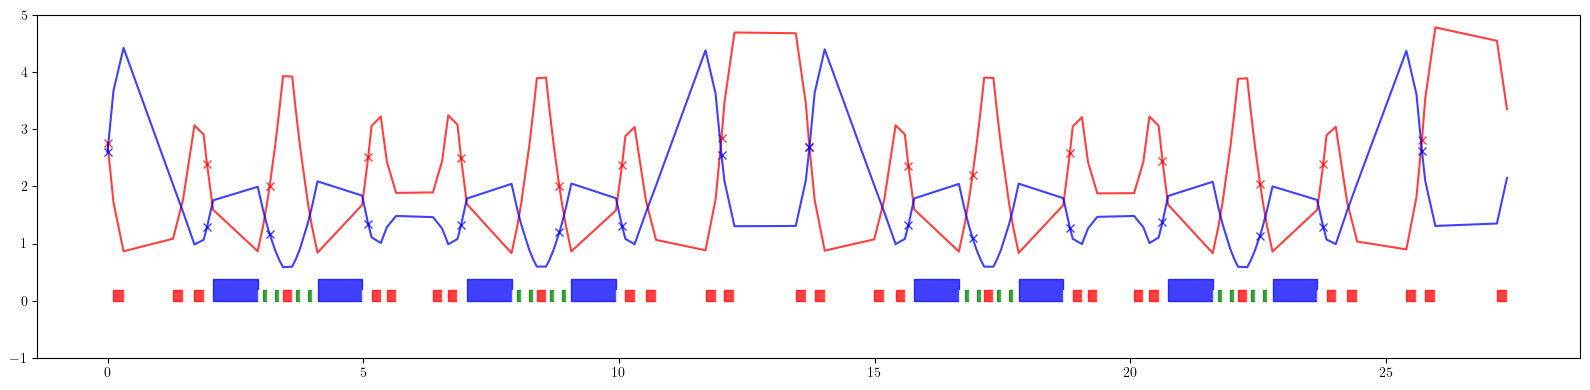

In [8]:
# Plot beta functions

layout = Layout(ring)
_, _, lengths, *_ = layout.slicing_table()
rectangles = layout.profile_1d(scale=0.75, shift=0.0, text=False,  exclude=['BPM', 'Corrector'])

plt.figure(figsize=(16, 4))
plt.errorbar(positions, b_qx.cpu().numpy(), fmt=' ', color='red', alpha=0.75, marker='x')
plt.errorbar(ring.locations().cpu().numpy(), bqxs.cpu().numpy(), fmt='-', color='red', alpha=0.75)
plt.errorbar(positions, b_qy.cpu().numpy(), fmt=' ', color='blue', alpha=0.75, marker='x')
plt.errorbar(ring.locations().cpu().numpy(), bqys.cpu().numpy(), fmt='-', color='blue', alpha=0.75)
for rectangle in rectangles:
    plt.gca().add_patch(Rectangle(**rectangle))
plt.ylim(-1.0, 5.0)
plt.tight_layout()
plt.show()

In [9]:
# convert flag usage

# onvert=True (default), coupled twiss parameters are converted to CS (ax, bx, ay, by)

print(twiss(ring, [], alignment=False, convert=True, matched=True, advance=True, full=False, guess=guess, limit=8, epsilon=1.0E-9).shape)

# convert=False, Wolski twiss matrices are returned (see PhysRevSTAB.9.024001 for details)

print(twiss(ring, [], alignment=False, convert=False, matched=True, advance=True, full=False, guess=guess, limit=8, epsilon=1.0E-9).shape)

torch.Size([136, 4])
torch.Size([136, 2, 4, 4])


In [10]:
# advance and full flag usage

# advance=False (default), Twiss parameters only for lattice start are returned

print(twiss(ring, [], alignment=False, matched=True, advance=False, full=False, guess=guess, limit=8, epsilon=1.0E-9).shape)

# advance=True and full=False, twiss parameters at element enterance are returned

print(twiss(ring, [], alignment=False, matched=True, advance=True, full=False, guess=guess, limit=8, epsilon=1.0E-9).shape)

# advance=True and full=Truee, twiss parameters between elements are returned

print(twiss(ring, [], alignment=False, matched=True, advance=True, full=True, guess=guess, limit=8, epsilon=1.0E-9).shape)

torch.Size([4])
torch.Size([136, 4])
torch.Size([137, 4])
